In [19]:
import findspark
import pyspark
import numpy as np
import pyspark.sql.functions as sqlFunctions
import matplotlib.pyplot as plt

from operator import add
from pyspark.sql import SQLContext

%matplotlib inline

In [20]:
findspark.init()
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

In [21]:
# Full original training set
raw_full_train = sc.textFile("dac/train.txt")

# Final test set split
raw_final_test = sc.textFile("dac/split/test.txt")  # Do not touch during training

# Training set splits
raw_test_3m = sc.textFile("dac/split/test_3m.txt")
raw_train_5m = sc.textFile("dac/split/train_5m.txt")
raw_validation_2m = sc.textFile("dac/split/train_5m.txt")

# Debug set
raw_small_train = sc.textFile("dac/small-train.txt")

In [22]:
def convert_value(index, value):
    if index < 14:
        return int(value) if value else None
    else:
        return value if value else None

def convert_line(line):
    return [convert_value(i, value) for i, value in enumerate(line.split("\t"))]

In [23]:
# Change the data types of the datasets so that the RDD's include Int's and Strings. 
full_train = raw_full_train.map(convert_line)
final_test = raw_final_test.map(convert_line)
test_3m = raw_test_3m.map(convert_line)
train_5m = raw_train_5m.map(convert_line)
validation_2m = raw_validation_2m.map(convert_line)

debug = raw_small_train.map(convert_line)

In [24]:
# Label data histogram
debug.map(lambda row: row[0]).histogram([0,1,2])

([0, 1, 2], [77337, 22663])

In [86]:
def int_column_histogram(col_num, col):
    bins, counts = col.histogram(10)
    total = sum(counts)    
    print "Column %d histogram\n\tBins=%s\n\tCounts=%s (total=%d)" % (col_num, bins, counts, total)
    # TODO: display graph of histogram
    # TODO: better buckets for histogram (smart sub-dividing)
        #sum the counts
        #max of the counts
        #if  > 25%
    return bins,counts

def int_columns_histograms(data):
    bins=[]; counts=[]
    for i, col in enumerate(column_iter(debug)):
        col_num = i + 1
        if is_integer_col_num(col_num):
            bins1,counts1 = int_column_histogram(col_num, col)
            bins.append(bins1) #bin values
            counts.append(counts1) #count inside bins
            
    return bins,counts

def bin_range_labels(bins):
    #Nicely display these. 
    return ["%s---%s" % ("{:.1E}".format((bins[i])),"{:.2E}".format((bins[i+1]))) for i in range(len(bins) - 1)]




In [26]:
def get_column_num(data, col_num):
    return data.map(lambda row: row[col_num])

def column_filter_null(column):
    return column.filter(lambda row: row is not None)

def column_count(data):
    return len(data.take(1)[0])

def is_integer_col_num(col_num):
    return col_num > 1 and col_num < 15

def is_label_col_num(col_num):
    return col_num == 1

def is_categorical_col_num(col_num):
    return col_num > 15

def column_iter(data):
    for i in range(column_count(data)):
         yield get_column_num(data, i)

In [27]:
def cat_columns_histogram(data):
    hashes=[]; counts_all=[]; remainder=[];
    
    for i, col in enumerate(column_iter(debug)):
        col_num = i + 1
        if is_categorical_col_num(col_num):
            key_counts = col.map(lambda key: (key, 1)).reduceByKey(add)
            sorted_counts = sorted(key_counts.collect(), key=lambda t: t[1], reverse=True)
            labels = [v[0] for v in sorted_counts]
            counts = [v[1] for v in sorted_counts]
            # TODO: graph these counts
            # TODO: truncate at something larger than 5
            hashes.append(labels[:10]) #bin values
            counts_all.append(counts[:10]) #count inside bins
            remainder.append(sum(counts[10:]))
            print labels[:10], counts[:10], "Remaining", sum(counts[10:])
            
#            return labels[:10],counts[:10],sum(counts[10:])
    return hashes,counts_all,remainder

In [90]:
x,y,z = cat_columns_histogram(debug)
x_int, y_int =int_columns_histograms(debug)

[u'38a947a1', u'09e68b86', u'80e26c9b', u'38d50e09', u'287130e0', u'4f25e98b', u'1cfdf714', u'207b2d81', u'08d6d899', u'd833535f'] [12895, 6826, 4043, 3724, 3269, 3268, 2903, 2366, 1988, 1892] Remaining 56826
[None, u'd032c263', u'b00d1501', u'02cf9876', u'aa8c1539', u'77f2f2e5', u'74e1a23a', u'9143c832', u'2cbec47f', u'ad4b77ff'] [3935, 3703, 1900, 1707, 1579, 1571, 1058, 972, 900, 855] Remaining 81820
[u'c18be181', u'd16679b9', None, u'85dd697c', u'13508380', u'f922efad', u'9a6888fb', u'f56b7dd5', u'3e2bfbda', u'29998ed1'] [5410, 4380, 3935, 3235, 2330, 1487, 1058, 972, 908, 895] Remaining 75390
[u'25c83c98', u'4cf72387', u'43b19349', u'384874ce', u'30903e74', u'0942e0a7', u'f281d2a7', u'b0530c50', u'b2241560', u'f3474129'] [67056, 15783, 6228, 3224, 1990, 1313, 874, 560, 483, 374] Remaining 2115
[u'7e0ccccf', u'fbad5c96', None, u'fe6b92e5', u'13718bbd', u'6f6d9be8', u'3bf701e7', u'e3520422', u'f1f2de2d', u'c05778d5'] [46438, 19331, 13708, 11495, 3802, 3460, 1728, 16, 9, 6] Remaining

In [84]:
# This represents the Histograms for Category Features. 
# For Integer Feature we do not compute "Other Values"
# 
# x_values = 1D array of the x_values {bins OR category names}
# y_values = 1D array of the y_values {counts of uniques in bins or category name}
# isCategory = True if feature is category. 
#            = False if feature is integer.
# Z_other_values = sum of the counts of the remaining categories for category feature.
#
#
def disp_Histogram(x_values,y_values,isCategory, column_numb,z_other_value=0):
        range_x = min(len(x_values),10)
        x1 = np.arange(range_x)
        x2 = []
        
        if (isCategory):
            type_of_feature = "Category"
            x_label = "Category as a Hashed value"
            #Add Other column
            for i in x_values: 
                x2.append(str(i))
            
            x1 = np.append(x1,10)
            x2.append('Other')
            print "HI",z_other_value
            y_values.append(z_other_value)

        else: 
            type_of_feature = "Integer"
            x_label = "Bins of Integer values"
            x2 = bin_range_labels(x_values)

        
        plt.title('%s Feature %s Histogram' % (type_of_feature,column_numb))
        plt.ylabel('Count of values')
        plt.xlabel('The %s' % x_label)
        print ("X: %s, Y: %s" % (x1,y_values))
        plt.xticks(x1, x2,rotation=45)
        print "X: %s, Y: %s" % (len(x1),len(y_values))
        plt.bar(x1, y_values,log=True)
        plt.show()

    

X: [0 1 2 3 4 5 6 7 8 9], Y: [55236, 295, 34, 10, 5, 3, 2, 0, 1, 1]
X: 10, Y: 10


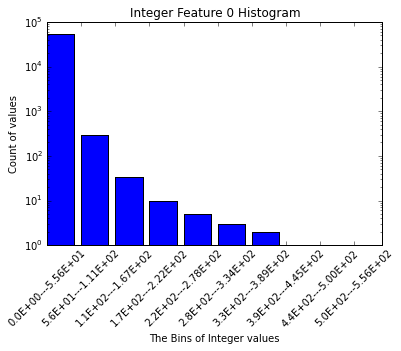

X: [0 1 2 3 4 5 6 7 8 9], Y: [98530, 1397, 52, 12, 7, 0, 1, 0, 0, 1]
X: 10, Y: 10


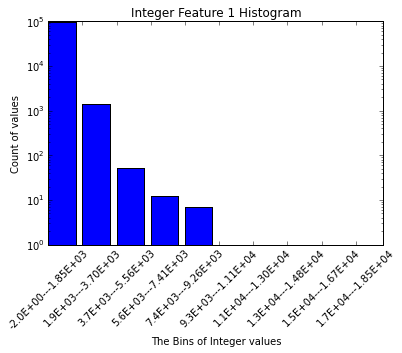

X: [0 1 2 3 4 5 6 7 8 9], Y: [80863, 11, 1, 20, 0, 0, 0, 0, 1, 2]
X: 10, Y: 10


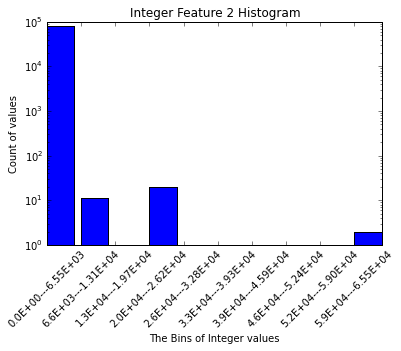

X: [0 1 2 3 4 5 6 7 8 9], Y: [79210, 1178, 44, 8, 12, 6, 5, 0, 0, 3]
X: 10, Y: 10


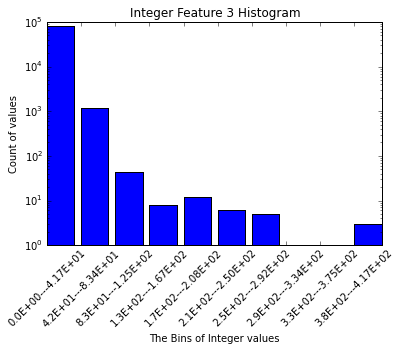

X: [0 1 2 3 4 5 6 7 8 9], Y: [93216, 1145, 491, 218, 88, 44, 19, 11, 5, 3]
X: 10, Y: 10


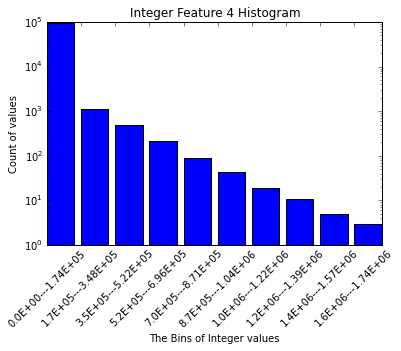

X: [0 1 2 3 4 5 6 7 8 9], Y: [74200, 536, 92, 36, 12, 10, 3, 1, 1, 2]
X: 10, Y: 10


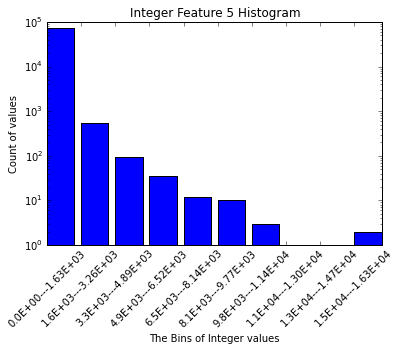

X: [0 1 2 3 4 5 6 7 8 9], Y: [95218, 51, 8, 2, 0, 0, 1, 0, 0, 1]
X: 10, Y: 10


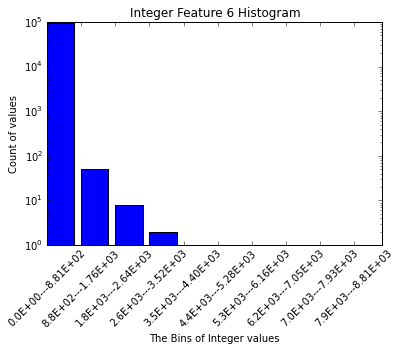

X: [0 1 2 3 4 5 6 7 8 9], Y: [99864, 11, 0, 0, 4, 4, 3, 1, 3, 3]
X: 10, Y: 10


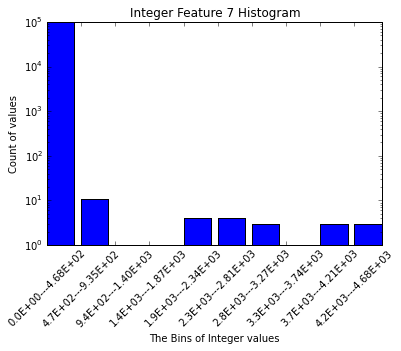

X: [0 1 2 3 4 5 6 7 8 9], Y: [94344, 735, 144, 30, 12, 13, 1, 1, 0, 1]
X: 10, Y: 10


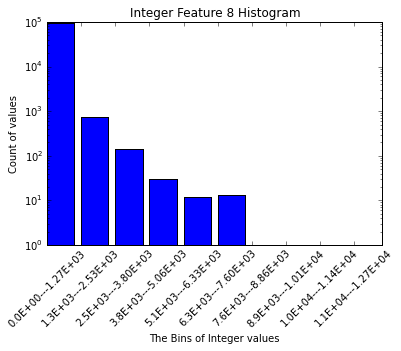

X: [0 1 2 3 4 5 6 7 8 9], Y: [26171, 25277, 0, 3409, 0, 580, 119, 0, 27, 4]
X: 10, Y: 10


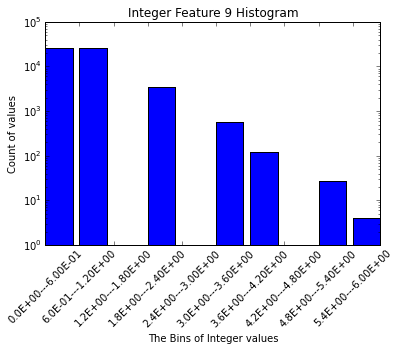

X: [0 1 2 3 4 5 6 7 8 9], Y: [91416, 2696, 765, 203, 82, 68, 26, 15, 4, 6]
X: 10, Y: 10


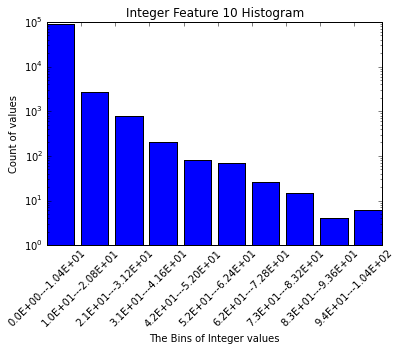

X: [0 1 2 3 4 5 6 7 8 9], Y: [22793, 21, 3, 2, 0, 0, 0, 0, 0, 1]
X: 10, Y: 10


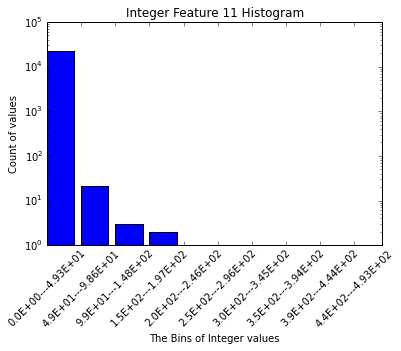

X: [0 1 2 3 4 5 6 7 8 9], Y: [80441, 6, 5, 5, 3, 2, 3, 0, 0, 1]
X: 10, Y: 10


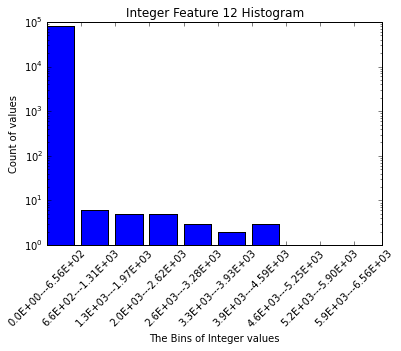

In [91]:
# The following Shows all the histograms for all of the features. 

def show_all_histograms(x,y,featureType,z_other_value=0):
    isCategory = True
     
    if featureType=="Integer":
        isCategory = False
       
        for i in range(len(x)):
            disp_Histogram(x[i],y[i],isCategory,i,z_other_value=0)
    else:
        isCategory = True
        for i in range(len(x)):
            print z_other_value[i]
            disp_Histogram(x[i],y[i],isCategory,i,z_other_value[i])

show_all_histograms(x_int,y_int,"Integer")

#show_all_histograms(x,y,"Category",z)


In [ ]:
int_columns_basic_summary_stats(debug)

In [ ]:
def print_column_summary_details(col_num, kurtosis, skewness):
    print("Column #%2d: Kurtosis=%-10.3f Skewness=%-10.3f" % (col_num, kurtosis, skewness))

def int_columns_detail_stats(data):
    df = sqlContext.createDataFrame(data)
    for i, col in enumerate(column_iter(data)):
        col_num = i + 1
        if is_integer_col_num(col_num):            
            col = df["_%s" % col_num]
            k_col = sqlFunctions.kurtosis(col)
            k_result = df.select(k_col.alias("kurtosis")).collect()[0]
            s_col = sqlFunctions.skewness(col)
            s_result = df.select(s_col.alias("skewness")).collect()[0]
            print_column_summary_details(col_num, k_result.kurtosis, s_result.skewness)

In [ ]:
int_columns_detail_stats(debug)

In [ ]:
a = int_columns_histograms(debug)

array([ 0,  1,  2,  3, 10, 10])

In [77]:
range_x = max(12,10)
range_x

12

In [70]:
y_values

NameError: name 'y_values' is not defined

In [87]:
bin_range_labels([1232423,1342342342])

['1.2E+06---1.34E+09']